# Test HRV-based segmentation

Reads HDCP2 HRV files and test segmentation options
   

In [4]:
%matplotlib inline

import os, sys, glob

import pylab as pl
pl.rcParams['figure.figsize'] = (16.0, 12.0)
pl.rcParams['font.size'] = 22.0

import numpy as np
import datetime
from l15_msevi.msevi import MSevi
import analysis_tools.statistics  as stats
import io_tools.netcdf as ncio
import analysis_tools.segmentation as seg

from standard_config import *

## Input HDCP2 Data

In [5]:
fdir = '%s/hdcp2' % local_data_path
fname = '%s/hdfd_trop_seviri00_l1_rssr_hrv_v00_20160606000000.nc' % fdir

vname = 'rssr_hrv'
itime = 120

h = ncio.read_icon_4d_data(fname, vname, itime = itime)[vname]

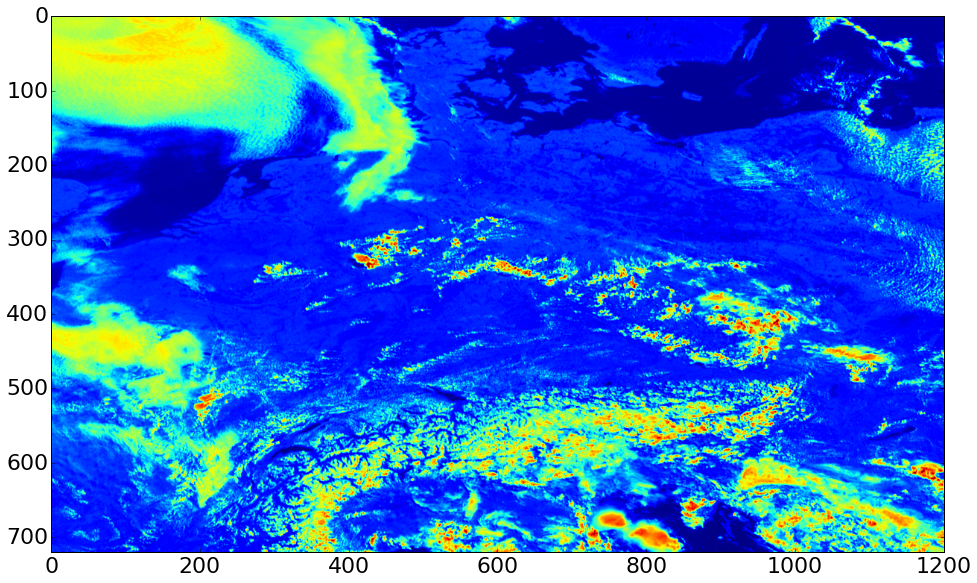

In [6]:
pl.imshow(h)

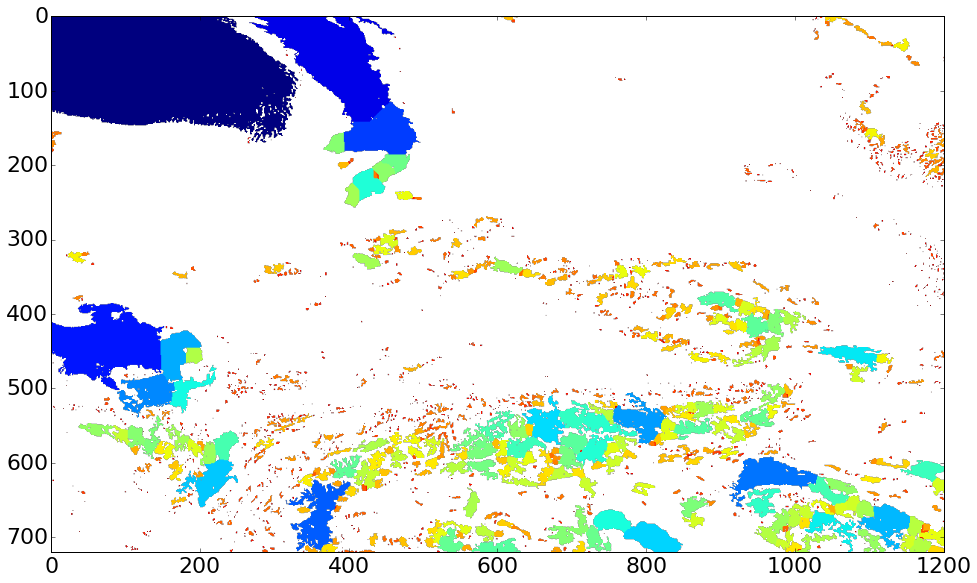

In [7]:
s = seg.watershed_clustering(h, 0.4, marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.3)
s = seg.sort_clusters(s)
pl.imshow(np.ma.log(s))

## Play with a cutout

In [8]:
i = (350, 600)
hc = gi.cutout_field4box(h, i, 100)

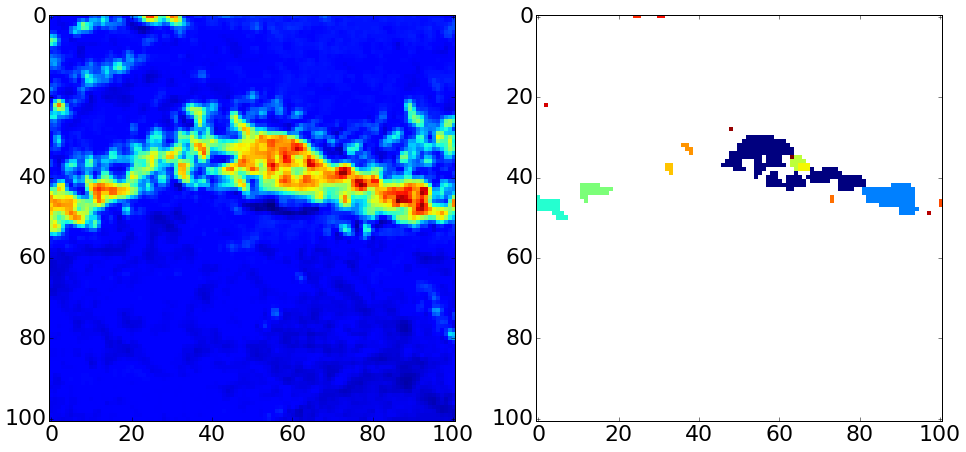

In [9]:
s = seg.watershed_clustering(hc, 0.7 * hc.max(), marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.3)
s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(hc, interpolation = 'nearest')
pl.subplot(122)
pl.imshow(np.ma.log(s), interpolation = 'nearest')


In [10]:
hc_sm = scipy.ndimage.uniform_filter(hc, 11)

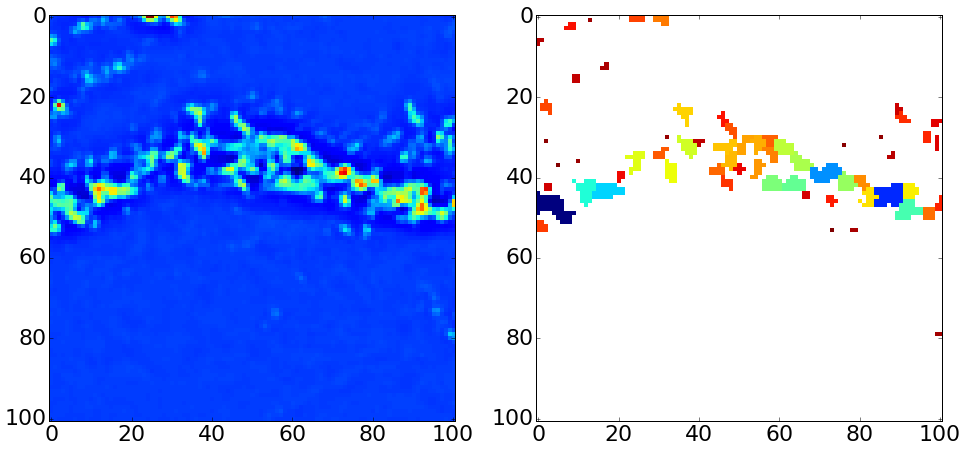

In [11]:
f = hc *  (hc - hc_sm)
thresh = 0.05

s = seg.watershed_clustering(f, thresh, marker_field = 'field', )#marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.1)
s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(f, interpolation = 'nearest')
pl.subplot(122)
pl.imshow(np.ma.log(s), interpolation = 'nearest')



## Full field again

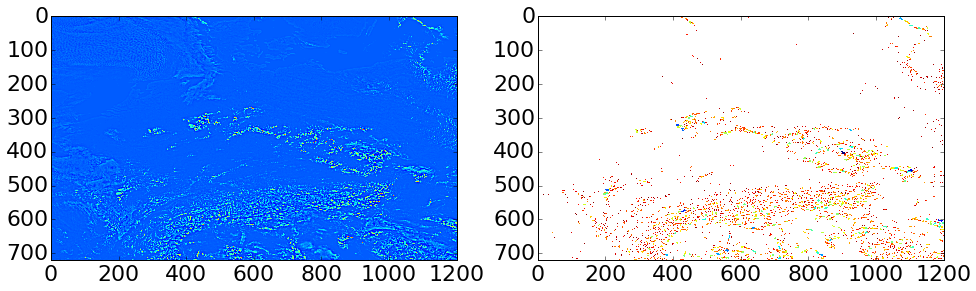

In [12]:
h_sm = scipy.ndimage.uniform_filter(h, 11)

f = h *  (h - h_sm)
thresh = 0.05

s = seg.watershed_clustering(f, thresh, marker_field = 'field', )#marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.1)
s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(f, interpolation = 'nearest')
pl.subplot(122)
pl.imshow(np.ma.log(s), interpolation = 'nearest')


## Iterative Shrinking based on Field values?

In [13]:
%loadpy /vols/talos/home/fabian/lib/tropy/analysis_tools/segmentation.py

In [ ]:
#!/usr/bin/env python

# Copyright (c) 2012- 2017

# TROPOS,
# Permoserstr. 15
# 04318 Leipzig, Germany. 

# Author:
# ====== 
# Fabian Senf <senf@tropos.de>


# This program is free software; you can redistribute it and/or 
# modify it under the terms of the GNU General Public License as 
# published by the Free Software Foundation; either version 3 of 
# the License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful, 
# but WITHOUT ANY WARRANTY; without even the implied warranty of 
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the 
# GNU General Public License for more details.


# load libraries -----------------------------------------------------
import sys, os, glob

import numpy as np
import datetime

import scipy.ndimage
import skimage.morphology
import skimage.feature
import skimage.measure
import mahotas as mh

import grid_and_interpolation as gi

######################################################################
######################################################################

def clustering(f, thresh, 
               cluster_method = 'watershed', 
               min_size = 20, 
               **kwargs):


    '''
    General interface to aplly either connectivity or watershed clustering.

    
    USAGE
    =====
    c = clustering(f, thresh, cluster_method = 'watershed', **kwargs)


    INPUT
    =====
    f: binary field
    thresh: threshold for masking, set foreground to f > thresh

    cluster_method: optional, either 'watershed' or 'connect' for 
                    watershed or connectivity clustering

    min_size: optional, minimum cluster size (px) left in the cluster field
 
    **kwargs: optional, keyword argument for selected cluster algorithm


    
    OUTPUT
    ======
    c: cluster field 
    '''

    if cluster_method == 'watershed':
        c = watershed_clustering(f, thresh, **kwargs)
        return remove_small_clusters(c, min_size = min_size)

    elif cluster_method == 'watershed_merge':
        return  watershed_merge_clustering(f, thresh, 
                                           min_size = min_size, 
                                           **kwargs)

    elif cluster_method == 'connect':
        c = connectivity_clustering(f, thresh, **kwargs)
        return remove_small_clusters(c, min_size = min_size)

    else:
        raise KeyError('Unkown cluster method')


######################################################################
######################################################################


def watershed_clustering(f, thresh, 
                         dradius = 3,
                         ctype = 4,
                         marker_field = 'dist',
                         filter_method = 'curve',
                         numberOfIterations = 5,
                         cluster_masking = True,
                         exclude_border = False,
                         marker_method = 'mahotas_regmax',
                         siggauss = 1.,
                         marker_shrinkage_Niter = 3,
                         marker_shrinkage_dmin = 0.1, 
                         **kwargs):

    '''
    Applies watershed clustering to a field.

    
    USAGE
    =====
    c =  watershed_clustering(f, thresh, dradius = 3, numberOfIterations = 5)


    INPUT
    =====
    f: binary field
    thresh: threshold for masking, set foreground to f > thresh
    
    marker_field: (optional) if 'dist', then max. in Euclidean distance to background
                             is used to set initial markers, else the max. in field f
                             are taken
    
    dradius: (optional) minimal distance for neighboring maxima
    ctype: (optional) 4 or 8 for 4- or 8-connectivity

    filter_method: (optional) either 'gauss' or 'curve' for 2d-Gaussian or curvature
                   flow filter  
    numberOfIterations: (optional) number of repeated application of curvature flow filter
                         the larger then smoother if selected
    siggauss: (optional) sigma for Gaussian filter if selected

    cluster_masking: (optional) if original (True) or smoothed (False) threshold mask is used.

    marker_method: (optional), set a method for marker assignment

       Options:
       -------
       'brute_force_local_max'  : just uses scipy.ndimage.maximum_filter
       'skimage_peak_local_max' : uses skimage local maximum routine
       'mahotas_regmax'         : uses mahotas regional maximum detection
       'iterative_shrinking'    : uses iterative object shrinking depending on 
                                       relative distance-to-background

 
   
    OUTPUT
    ======
    c: cluster field 
    '''

    # apply filtering ------------------------------------------------
    ndim = np.ndim( f )
    if filter_method == 'curve':
        f_sm = gi.curve_flow_filter(f, numberOfIterations = numberOfIterations)
    elif filter_method == 'gauss':
        f_sm = scipy.ndimage.gaussian_filter(f,  siggauss)
    # ================================================================


    # do masking -----------------------------------------------------
    ma = f > thresh
    ma_sm = f_sm > thresh
    # ================================================================


    # apply distance transform ---------------------------------------
    
    if marker_field == 'dist':
        mfield = scipy.ndimage.distance_transform_edt(ma_sm)
    else:
        mfield = np.where(f_sm < thresh, 0, f_sm - thresh)
    # ================================================================


    
    # find local maximaand set markers -------------------------------
    if type(marker_field) == type(np.array([])):

        markers = marker_field
        print '...take predefined marker field'

    elif marker_method == 'brute_force_local_max': 

        mfield_max = scipy.ndimage.maximum_filter(mfield, 2*dradius + 1) 
        local_maxi = (mfield_max == mfield) & ma_sm
        markers, nclust = scipy.ndimage.label(local_maxi)

    elif marker_method == 'skimage_peak_local_max':

        local_maxi = skimage.feature.peak_local_max(mfield, 
                                                indices = False, 
                                                exclude_border = exclude_border,
                                                min_distance = dradius)
        markers, nclust = scipy.ndimage.label(local_maxi)

    elif marker_method == 'mahotas_regmax':

        local_maxi = mh.regmax( mfield, Bc = 2*dradius + 1)
        markers, nclust = scipy.ndimage.label(local_maxi)


    elif marker_method == 'iterative_shrinking':

        markers = markers_from_iterative_shrinking(ma_sm,
                                        marker_shrinkage_Niter = marker_shrinkage_Niter,
                                        marker_shrinkage_dmin = marker_shrinkage_dmin,
                                        **kwargs)

    # ================================================================


    # watersheding ----------------------------------------------------
    connect = set_connectivity_footprint(ctype, ndim)

    c = skimage.morphology.watershed(-mfield, markers, 
                                     mask = ma_sm,
                                     connectivity = connect)
    # ================================================================


    # use original mask ----------------------------------------------
    if cluster_masking:
        c = np.where(ma, c, 0)
    # ================================================================

    return c


######################################################################
######################################################################


def connectivity_clustering(f, thresh, 
                            filter_method = 'curve',
                            numberOfIterations = 5,
                            ctype = 4,                         
                            cluster_masking = True,
                            siggauss = 1.,
                            **kwargs):

    '''
    Applies connectivity clustering to a field.

    
    USAGE
    =====
    c =   connectivity_clustering(f, thresh, **kwargs)


    INPUT
    =====
    f: binary field
    thresh: threshold for masking, set foreground to f > thresh
    
    ctype: (optional) 4 or 8 for 4- or 8-connectivity


    filter_method: (optional) either 'gauss' or 'curve' for 2d-Gaussian or curvature
                   flow filter  
 
    numberOfIterations: (optional) number of repeated application of curvature flow filter
                         the larger then smoother if selected
    siggauss: (optional) sigma for Gaussian filter if selected

    cluster_masking: (optional) if original (True) or smoothed (False) threshold mask is used.

    
    OUTPUT
    ======
    c: cluster field 
    '''

    # apply filtering ------------------------------------------------
    ndim = np.ndim( f )
    if filter_method == 'curve':
        f_sm = gi.curve_flow_filter(f, numberOfIterations = numberOfIterations)
    elif filter_method == 'gauss':
        f_sm = scipy.ndimage.gaussian_filter(f,  siggauss)
    # ================================================================


    # do masking -----------------------------------------------------
    ma = f > thresh
    ma_sm = f_sm > thresh
    # ================================================================


    # connectivity --------------------------------------------------- 
    connect =  set_connectivity_footprint(ctype, ndim)
    c, nclust = scipy.ndimage.label(ma_sm, connect)
    # ================================================================


    # use original mask ----------------------------------------------
    if cluster_masking:
        c = np.where(ma, c, 0)
    # ================================================================

    return c




######################################################################
######################################################################

def watershed_merge_clustering(f, thresh, 
                               min_size = 20,
                               merge_ratio = 0.5,
                               **kwargs):

    '''
    
    Applies watershed clustering to a field and then tries to merge them again.

    The merging is based on the ratio between maximum distances-to-background 
    within the subclusters and on the cluster broders.

    
    USAGE
    =====
    c =  watershed_clustering(f, thresh, **kwargs)


    INPUT
    =====
    f: binary field
    thresh: threshold for masking, set foreground to f > thresh
    min_size: minimum cluster size

    merge_ratio: optional, most important parameter which determines when clusters
                 are merged, ratio between maximal in-cluster and cluster edge distance
    
    **kwargs: keywords of the watershed_cluster routine


    OUTPUT
    ======
    c_update: updated cluster field

    '''
  

    # LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
    # Section 1: split the existing cluster into smaller parts
    # TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


    # split the field using watershed segmentation -------------------
    cw =  watershed_clustering(f, thresh, **kwargs)

    # sort clusters ... THIS MIGHT BE REMOVED ....
    # cw = remove_small_clusters(cw, 0)
    # ================================================================



    # LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
    # Section 2:  get information about the borders
    # TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


    # use dilattion to expand the original field ---------------------
    cadd = scipy.ndimage.maximum_filter(cw, 3)

    # get edge or border from difference between the fields 
    cedge = np.where(cw == 0, 0, cw - cadd)


    # the number of two touching clusters are extracted
    c1 = cw[ cedge != 0 ]
    c2 = cadd[ cedge != 0 ]

    # now we collect all possible combinations of touching clusters
    touching_clusters = set( zip(c1, c2) )
    # ================================================================



    # LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
    # Section 3: test for merging
    # TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT


    # get distance field ---------------------------------------------
    dist = scipy.ndimage.distance_transform_edt(f > thresh)
    # ================================================================


    # loop over all combinations -------------------------------------
    merging_clusters = []
    for nc1, nc2 in sorted(touching_clusters) :

        # set cluster masks
        mask1 = (cw == nc1)
        mask2 = (cadd == nc2)

        # generate edge mask
        edge_mask = (cedge !=0 ) & mask1 & mask2

        # maximal distances-to-background within the clusters
        d1_max = dist[mask1].max()
        d2_max = dist[mask2].max()

        # now take the smaller one
        d_max = np.minimum(d1_max, d2_max)
        
        d_edge_max = dist[edge_mask].max()

        # calculate distance ratio
        dist_ratio = d_edge_max / d_max
        if dist_ratio > merge_ratio:
            merging_clusters += [(nc1, nc2)]
    # ================================================================




    # LLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLL
    # Section 4: apply all merges
    # TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
    
    # get lists of connected clusters
    connected_clusters = connected_sequences2pairlists( merging_clusters )
    
    for nmerge in connected_clusters.keys():

        # list of clusters that should be merged
        mlist =  connected_clusters[nmerge]
        nc_target = mlist[0]
        for m in mlist[1:]:
            cw = np.where(cw == m, nc_target, cw)
        
        
    # this sorts the stuff agian
    c_update = remove_small_clusters(cw, min_size = min_size)

    return c_update
    

######################################################################
######################################################################


def connected_sequences2pairlists( connected_pairs_list ):

    '''
    The routine gets a set of paired numbers which show connection between numbers
    and collects all connections in a list of pairs.


    INPUT
    =====
    connected_pairs_list: list of number pairs


    OUTPUT
    =====
    pair_list: dictionary that contains pair lists

    '''

    merging_clusters = connected_pairs_list[:]
    
    pair_list = {} 
    cluster_list_copy = merging_clusters[:]
    i = 1


    while len(cluster_list_copy) != 0:
        NOT_CONVERGED = True
        pair_list[i] = list( merging_clusters.pop(0) )
       
        while NOT_CONVERGED:
            for pair in merging_clusters:
                c1, c2 = pair
                FOUND = False
        
                if c1 in pair_list[i]:
                    pair_list[i] += [c2,]
                    FOUND = True
        
                if c2 in pair_list[i]:
                    pair_list[i] += [c1,]
                    FOUND = True
                   
                if FOUND:
                    cluster_list_copy.remove(pair)
    
            # check if something changed
            NOT_CONVERGED = (merging_clusters != cluster_list_copy)
    
            merging_clusters = cluster_list_copy[:]

        i += 1


    for npair in pair_list:
        pair_list[npair] = sorted( list( set(  pair_list[npair] ) ) )
    
    return pair_list

######################################################################
######################################################################

def markers_from_iterative_shrinking(mask,
                                     marker_shrinkage_Niter = 3,
                                     marker_shrinkage_dmin = 0.1, 
                                     **kwargs):

    

    '''
    The routine tries to find core parts of objects via iterative shrinking.
    
    Each object is normalized by its maximum distance-to-background which 
    makes the algorithm scale-invariant.


    INPUT
    =====
    mask: binary mask
    marker_shrinkage_Niter: optional, number of iterations performed
    marker_shrinkage_dmin: optional, relative distance threshold used of masking to
                           shrink the objects



    OUTPUT
    =====
    markers: markers field with increasing index per marker region
    '''

    

    # precalculate the distance transform ----------------------------
    d = scipy.ndimage.distance_transform_edt( mask )
    # ================================================================


    # connectivity analysis for segmentation -------------------------
    c = connectivity_clustering(d, 0, **kwargs)
    # ================================================================

    
    for niter in range( marker_shrinkage_Niter ):

        # get maximum distance-to-background per object ------------------
        dmax = scipy.ndimage.measurements.maximum(d, 
                                                  labels = c, 
                                                  index=range(c.max()+1))
        # ================================================================


        # get normed distance -> max. = 1 per object ---------------------
        dnorm = np.where(dmax[c] == 0, 0, d / dmax[c])
        # ================================================================


        # perform segmentation on normed distance ------------------------
        cnorm = connectivity_clustering(dnorm, marker_shrinkage_dmin, **kwargs)
        # ================================================================


        # get new initial values -------------------------------------
        c = cnorm
        d = scipy.ndimage.distance_transform_edt( c != 0 )
        # ============================================================


    # cluster field as output ----------------------------------------
    markers = c
    # ================================================================
    
    return markers
                                     

######################################################################
######################################################################




def set_connectivity_footprint(ctype, ndim):
    
    '''
    Return connectivity footprint for either 4-connectivity or 
    8-connectivity.

    4-connectivity only includes neigboring sides, 8-connectivity also 
    includes neighboring diagonal values.


    USAGE
    =====
    footprint = set_connectivity_footprint(ctype, ndim)

    
    INPUT
    =====
    ctype: connectivity type (either 4 or 8)
    ndim: dimension of the field (either 2 or 3)

    
    OUTPUT
    ======
    footprint: ndim-dimensional connectivity footprint
    '''

    if ctype == 4:

        if ndim == 2:
            footprint = np.array([
                [0, 1, 0],
                [1, 1, 1],
                [0, 1, 0]])

        elif ndim == 3:
            footprint = np.array([
                [[ 0,  0,  0],
                 [ 0,  1,  0],
                 [ 0,  0,  0]],
                                
                [[ 0,  1,  0],
                 [ 1,  1,  1],
                 [ 0,  1,  0]],

                [[ 0,  0,  0],
                 [ 0,  1,  0],
                 [ 0,  0,  0]]])

            
    elif ctype == 8:
            footprint = np.ones([3,]*ndim)

    return footprint

######################################################################
######################################################################

def sort_clusters(c):

    '''
    It sorts clusters by size (number of pixels) in decreasing order.

    
    USAGE
    =====
    c_re =  sort_clusters(c)


    INPUT
    =====
    c: categorial cluster field

    
    OUTPUT
    ======
    c_re: cleaned cluster field with cluster larger than min_size
    '''

    c_re = remove_clustersize_outside(c, 
                                        min_size = 0, 
                                        max_size = np.inf)
    return c_re



######################################################################
######################################################################



def remove_small_clusters(c, min_size = 6):

    '''
    Counts numbers of pixels per cluster cell and removes clusters smaller
    than minimum size. 

    In addition, it sorts clusters by size in decreasing order.

    
    USAGE
    =====
    c_re =  remove_small_clusters(c,  min_size = 6, sort = True)


    INPUT
    =====
    c: categorial cluster field
    min_size: (optional), minimum size of clusters that are retained
    sort: (optional) if True, cluster category numbers are sorted by size

    
    OUTPUT
    ======
    c_re: cleaned cluster field with cluster larger than min_size
    '''

    return remove_clustersize_outside(c, min_size = min_size)


######################################################################
######################################################################


def remove_clustersize_outside(c, 
                               min_size = 6, 
                               max_size = np.inf):

    '''
    Counts numbers of pixels per cluster cell and removes clusters outside
    a size range defined by a minimum and maximum size. 

    In addition, it sorts clusters by size in decreasing order.

    
    USAGE
    =====
    c_re =  remove_clustersize_outside(c,  min_size = 6,  
                                           max_size = np.inf, 
                                           sort = True)


    INPUT
    =====
    c: categorial cluster field
    min_size: (optional), minimum size of clusters that are retained
    max_size: (optional), maximum size of clusters that are retained
    sort: (optional) if True, cluster category numbers are sorted by size

    
    OUTPUT
    ======
    c_re: cleaned cluster field with clusters within a certain size range
    '''

    # set binary mask
    mask = np.where(c == 0, 0, 1)

    # get pixel sums per object
    psum = scipy.ndimage.measurements.sum(mask, 
                labels = c,  
                index = range( c.max()+1))

    # how is pixel sum sorted? Biggest first ...
    isort = psum.argsort()[::-1]

    
    # set up the scoring of pixel sums 
    score = np.arange(len(psum)) + 1

    
    # get the mapping
    imap = np.zeros_like(psum).astype( np.int )
    imap[isort] = score


    # conditions
    imap[ psum <= min_size ] = 0
    imap[ psum >= max_size ] = 0

    c_re = imap[c]

    return c_re



######################################################################
######################################################################


def remove_clustersize_outside_slow(c, 
                                    min_size = 6, 
                                    max_size = np.inf, 
                                    sort = True):

    '''
    OLD VERSION --> much slower ...

    Counts numbers of pixels per cluster cell and removes clusters outside
    a size range defined by a minimum and maximum size. 

    In addition, it sorts clusters by size in decreasing order.

    
    USAGE
    =====
    c_re =  remove_clustersize_outside(c,  min_size = 6,  
                                           max_size = np.inf, 
                                           sort = True)


    INPUT
    =====
    c: categorial cluster field
    min_size: (optional), minimum size of clusters that are retained
    max_size: (optional), maximum size of clusters that are retained
    sort: (optional) if True, cluster category numbers are sorted by size

    
    OUTPUT
    ======
    c_re: cleaned cluster field with clusters within a certain size range
    '''


    # calculate cluster sizes ----------------------------------------
    clust_size = {}

    # init new number index and cluster field
    c_re = np.zeros_like(c)
    cnum_new = 1

    # also init mapping between size and number of field
    csizes = []
    
    for cnum in range(1, c.max() + 1):

        # set mask
        m = (c == cnum)

        # get size
        csize =  len(c[m])
        clust_size[cnum] = csize

        # assign new number to cluster that is large enough
        if csize >= min_size and csize <= max_size:

            c_re[m] = cnum_new
            csizes.append(csize)

            cnum_new += 1

            
    # sort the field by cluster size
    if sort:
        
        csizes = np.array(csizes)
        cindices = csizes.argsort()[::-1]

        csort = np.zeros_like(c)

        for ci_new, ci_old in enumerate(cindices):
            m = (c_re == ci_old + 1)
            csort[m] = ci_new + 1

        cout = csort
    else:
        cout = c_re
    # ================================================================

    return cout
      
######################################################################
######################################################################

def percentiles_from_cluster(f, c, p = [25, 50, 75], index = None):

    '''
    Calculates percentiles of cells in an segmented (labeled) field.

    Functionality missing in scipy.ndimage.measurements.

    INPUT
    =====
    f: the field as basis for percentile calculation
    c: labeled field
    p: optional, percentiles array


    OUTPUT
    ======
    pc: array of percentiles per cell (including background (set to zero))
    '''

    # get slices .....................................................
    slices = scipy.ndimage.measurements.find_objects(c)


    # set index
    if index == None:
        index = range(1, len(slices) + 1)

    # loop over slices ...............................................

    nperc = len(p)
    pc = [np.zeros(nperc),]

    for i in index:

        try:
            s = slices[i- 1]
            cc = c[s]
            fc = f[s]
        
            m = (cc == i)  # assume that slices are sorted 
        
            pvec =  np.percentile( fc[m], p )
        except:
            pvec = np.nan * np.ones(nperc)

        pc.append( pvec )

    return pc
            

######################################################################
######################################################################


if __name__ == "__main__":

    # do the test with random field ----------------------------------
    r = np.random.randn(100, 100)
    r_sm = scipy.ndimage.median_filter(r, 5)
    rm = np.where(r_sm > 0.1, r_sm, 0)
    # ================================================================


    # connectivity ---------------------------------------------------
    c_con = connectivity_clustering(rm, 0)
    c_wat_mark = watershed_clustering(rm, 0)
    c_wat = watershed_clustering(rm, 0, 
                                 marker_field = 'same',
                                 dradius = 6)
    # ================================================================

                     

    import matplotlib
    matplotlib.use('Agg')
    import pylab as pl

    pl.subplot(221)
    pl.imshow(np.ma.masked_equal(rm,0))
    pl.subplot(222)
    pl.imshow(np.ma.masked_equal(c_con,0), cmap = pl.cm.prism)
    pl.subplot(223)
    pl.imshow(np.ma.masked_equal(c_wat_mark,0), cmap = pl.cm.prism)

    pl.subplot(224)
    pl.imshow(np.ma.masked_equal(c_wat,0), cmap = pl.cm.prism)

    






In [14]:
#!/usr/bin/env python

# Copyright (c) 2012- 2017

# TROPOS,
# Permoserstr. 15
# 04318 Leipzig, Germany. 

# Author:
# ====== 
# Fabian Senf <senf@tropos.de>


# This program is free software; you can redistribute it and/or 
# modify it under the terms of the GNU General Public License as 
# published by the Free Software Foundation; either version 3 of 
# the License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful, 
# but WITHOUT ANY WARRANTY; without even the implied warranty of 
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the 
# GNU General Public License for more details.


# load libraries -----------------------------------------------------
import sys, os, glob

import numpy as np
import datetime

import scipy.ndimage
import skimage.morphology
import skimage.feature
import skimage.measure
import mahotas as mh


from analysis_tools.segmentation import connectivity_clustering

In [15]:
######################################################################
######################################################################

def markers_from_iterative_field_shrinking(field, thresh, 
                                         marker_shrinkage_Niter = 3,
                                         marker_shrinkage_dmin = 0.1, 
                                         **kwargs):

    

    '''
    The routine tries to find core parts of objects via iterative shrinking.
    
    Each object is normalized by its maximum distance-to-background which 
    makes the algorithm scale-invariant.


    INPUT
    =====
    mask: binary mask
    marker_shrinkage_Niter: optional, number of iterations performed
    marker_shrinkage_dmin: optional, relative distance threshold used of masking to
                           shrink the objects



    OUTPUT
    =====
    markers: markers field with increasing index per marker region
    '''

    

    # precalculate the distance transform ----------------------------
    f = np.where(field < thresh, 0, field - thresh)
    # ================================================================


    # connectivity analysis for segmentation -------------------------
    c = connectivity_clustering(f, 0, **kwargs)
    # ================================================================

    
    for niter in range( marker_shrinkage_Niter ):

        # get maximum distance-to-background per object ------------------
        fmax = scipy.ndimage.measurements.maximum(f, 
                                                  labels = c, 
                                                  index=range(c.max()+1))
        # ================================================================


        # get normed distance -> max. = 1 per object ---------------------
        fnorm = np.where( fmax[c] == 0, 0, f / fmax[c] )
        # ================================================================


        # perform segmentation on normed distance ------------------------
        cnorm = connectivity_clustering(fnorm, marker_shrinkage_dmin, **kwargs)
        # ================================================================


        # get new initial values -------------------------------------
        c = cnorm
        f = np.where(fnorm < marker_shrinkage_dmin, 0, fnorm - marker_shrinkage_dmin )
        # ============================================================


    # cluster field as output ----------------------------------------
    markers = c
    # ================================================================
    
    return markers
                                     

######################################################################
######################################################################




...take predefined marker field


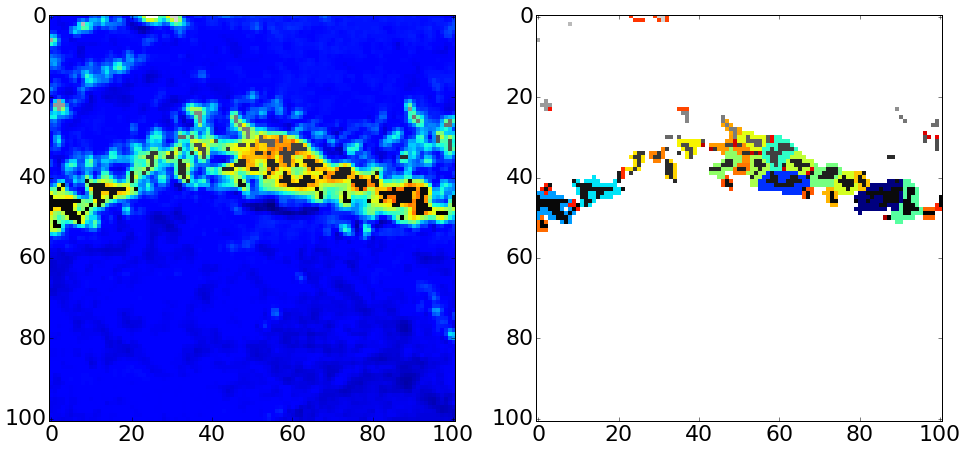

In [16]:
import analysis_tools.segmentation
reload(analysis_tools.segmentation)
import analysis_tools.segmentation as seg

m = markers_from_iterative_field_shrinking(hc, 0.5, marker_shrinkage_dmin = 0.1, marker_shrinkage_Niter=10 )

c = seg.watershed_clustering(hc, 0.5, marker_field = m)
c = seg.sort_clusters(c)

s = seg.connectivity_clustering(hc, 0.5, numberOfIterations=0)

pl.subplot(121)
pl.imshow(hc, interpolation = 'nearest')
pl.imshow(np.ma.log(m), cmap = pl.cm.gray_r, interpolation = 'nearest')

pl.subplot(122)

pl.imshow(np.ma.log(c), interpolation = 'nearest')
pl.imshow(np.ma.log(m), cmap = pl.cm.gray_r, interpolation = 'nearest')


## Masked Gauss Filter to identify local Max

In [17]:

def masked_gaussian_filter_nd(v, sigvec):


    '''
    Applies scipy.ndimage.gaussian_filter to numpy masked array.

    INPUT
    =====
    v: numpy masked array of rank n
    sigvec: Gaussian smoothing width, single-valued or vector of
            rank n

    OUTPUT
    ======
    v_sm: smoothed data field as masked array



    '''

    # 1st do smoothing of the data field
    v.data[v.mask] = 0.
    vgauss = scipy.ndimage.gaussian_filter(v.data.astype(np.float), sigvec)


    # 2nd do smoothing of the mask
    ma = np.where(v.mask, 0., 1.)
    ma_sm = scipy.ndimage.gaussian_filter(ma, sigvec)

    #wmin = 0.6
    #ma_sm[ma_sm < wmin] = 0


    # calculate the smoothed field by changing the weights
    v_sm = np.ma.masked_invalid( vgauss / ma_sm )

    return np.ma.masked_where(v.mask, v_sm)


######################################################################
######################################################################



...take predefined marker field


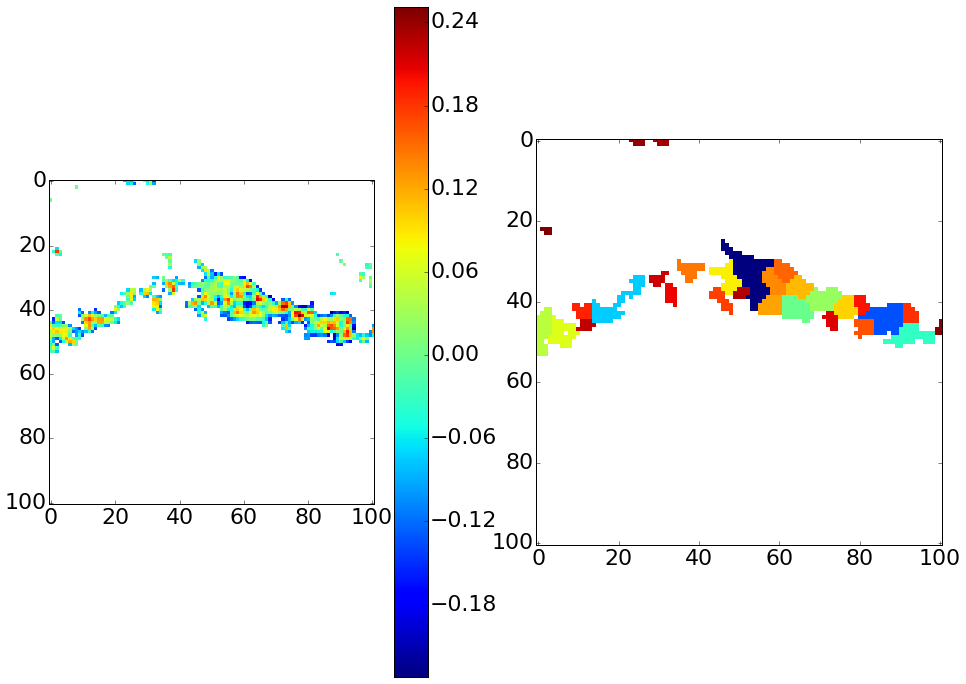

In [18]:
thresh = 0.5
hm = np.ma.masked_less(hc, thresh)

fthresh = 0.1
f = (hc - masked_gaussian_filter_nd(hm, 3))
f.data[f.mask] = 0.

s = seg.watershed_clustering(f, fthresh, marker_field = 'field', numberOfIterations=0)#marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.1)
s = seg.watershed_clustering(hc, thresh, marker_field = s)
s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(f, interpolation = 'nearest')
pl.colorbar()

pl.subplot(122)
pl.imshow(np.log(s), interpolation = 'nearest')



...take predefined marker field


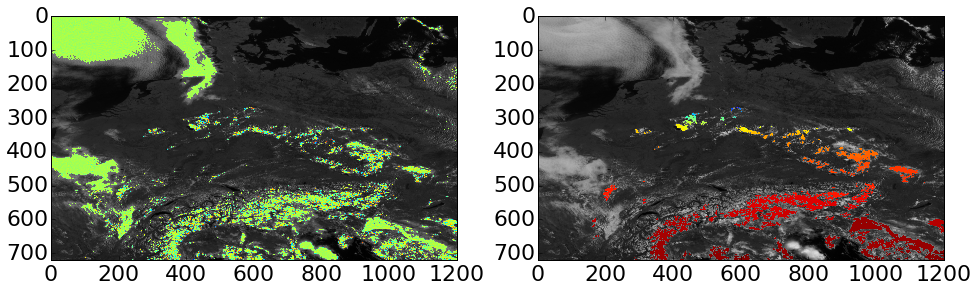

In [19]:
thresh = 0.5
hm = np.ma.masked_less(h, thresh)

fthresh = 0.1
f = (h - masked_gaussian_filter_nd(hm, 1))
f.data[f.mask] = 0.

s = seg.watershed_clustering(f, fthresh, marker_field = 'field', numberOfIterations=0)#marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.1)
s = seg.watershed_clustering(h, thresh, marker_field = s, numberOfIterations=0)
#s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(h, cmap = pl.cm.gray)
pl.imshow(f, interpolation = 'nearest')

pl.subplot(122)
pl.imshow(h, cmap = pl.cm.gray)
pl.imshow(np.log(s), interpolation = 'nearest')

## H-Res CMa based

In [20]:
fdir = '%s/hdcp2' % local_data_path
fname = '%s/hdfd_trop_seviri00_l1_rssr_hrv_v00_20140729000000.nc' % fdir

vname = 'rssr_hrv'
itime = 120

h = ncio.read_icon_4d_data(fname, vname, itime = itime)[vname]

In [21]:
dt = ncio.read_icon_4d_data(fname, 'time', itime = itime)['time']
t0 = datetime.datetime(1970, 1, 1)
t = t0 + datetime.timedelta(seconds = np.float(dt))

In [22]:
np.float(dt)

1406628000.0

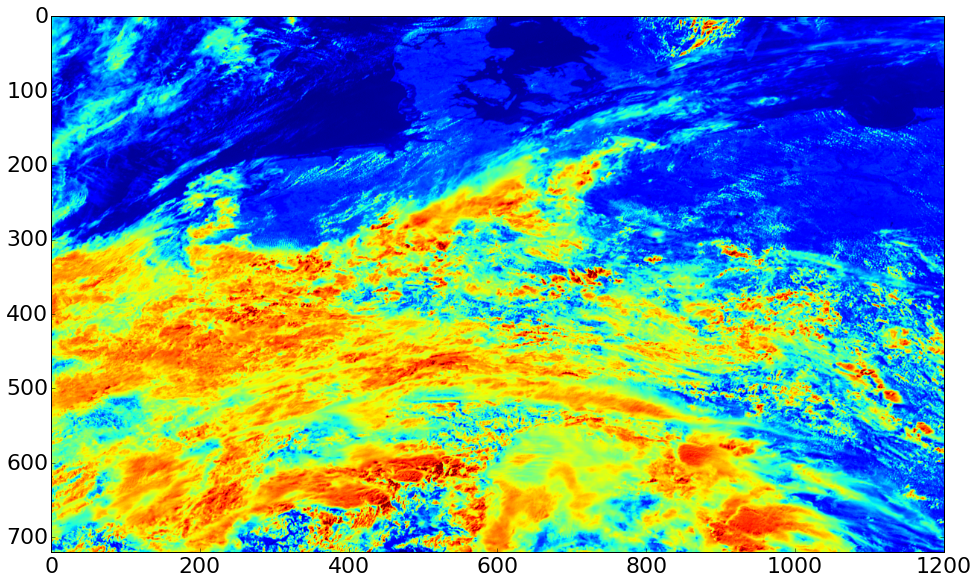

In [23]:
pl.imshow(h)

In [24]:
import MSGtools
reload(MSGtools)

<module 'MSGtools' from '/vols/talos/home/fabian/lib/tropy/MSGtools.pyc'>

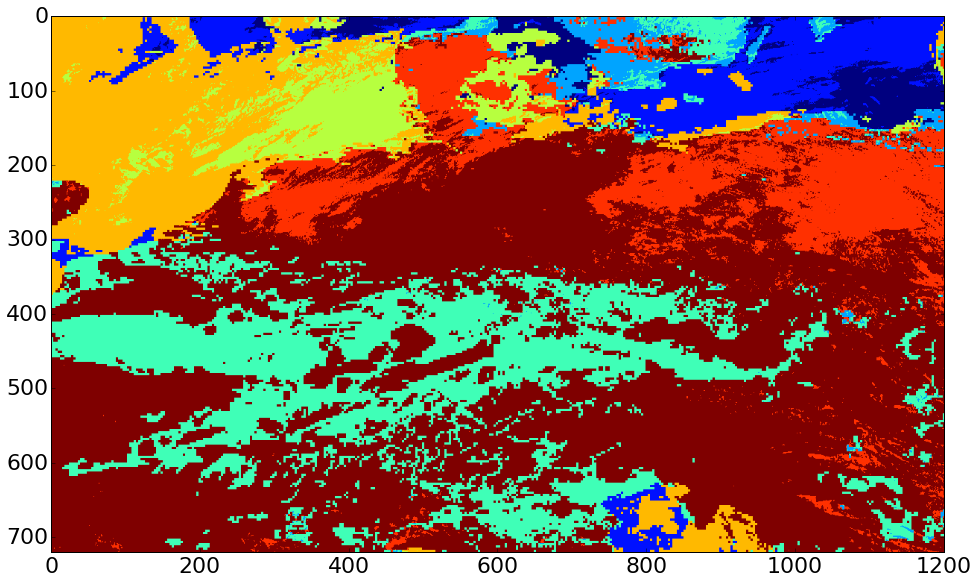

In [25]:
hrvma = MSGtools.get_highres_cma(t)
pl.imshow(hrvma)

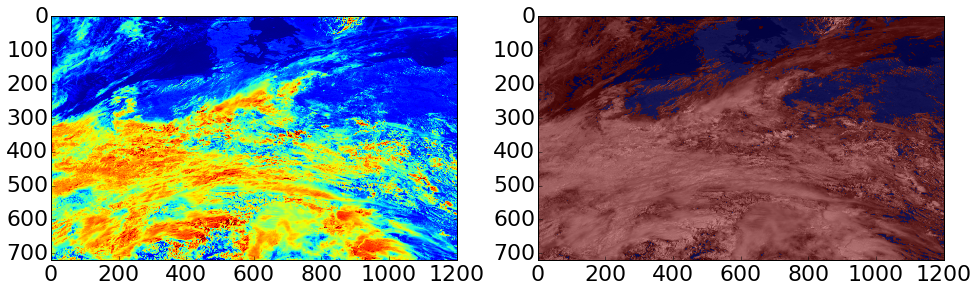

In [61]:
pl.subplot(121)
pl.imshow(h)
pl.subplot(122)
pl.imshow(h, cmap = pl.cm.gray)
#pl.imshow(np.mod(hrvma / 4, 2), alpha = 0.5)
pl.imshow(hrvma & 0x1, alpha = 0.5)


In [132]:
def deregion( res = 'low' ):

    # defined region - hard-coded sorry ...
    col0 = 1676; lin0 = 216; ncol = 400; nlin = 240
    x0 = 156
    y0 = 1356
    
    c0 = col0-y0
    l0 = lin0-x0
    c1 = c0 + ncol
    l1 = l0 + nlin
    
    reg = ((l0, l1), (c0, c1))
    hrv_region = ((3*l0, 3*l1), (3*c0, 3*c1))

    if res == 'low':
        return reg
    elif res == 'high':
        return hrv_region
    

In [133]:
def low2highres_decut(vlow):

    reg = deregion()

    vhigh = gi.cutout_fields(vlow, reg).repeat(3, axis = 0).repeat(3, axis= 1)

    return vhigh

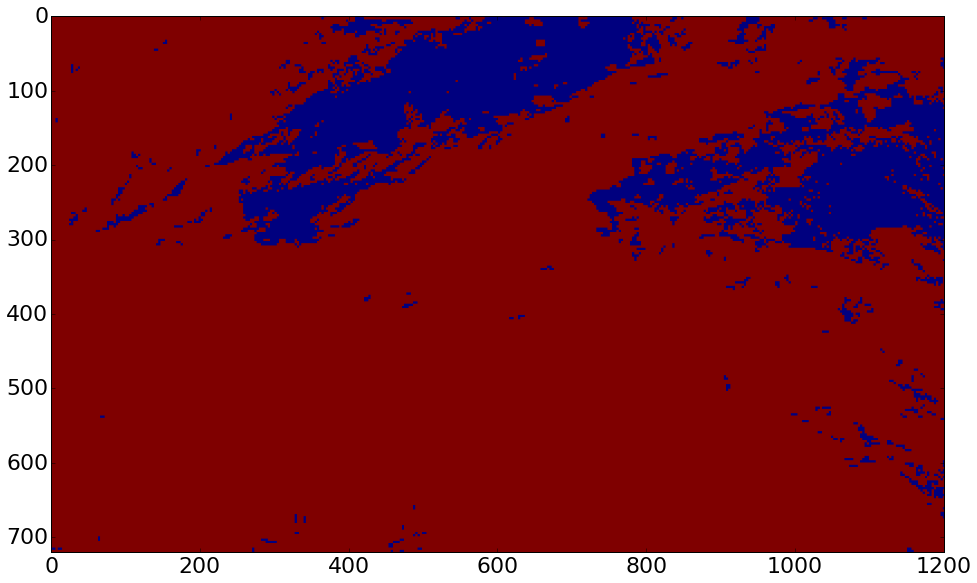

In [95]:
cma = MSGtools.get_nwcsaf_prod('CMa', t, calibrate = True, scan_type = 'rss')
cc = low2highres_decut(cma)
cc = np.where(cc > 1, 1, 0)


pl.imshow(cc)
#pl.imshow(cc - np.mod(hrvma / 1, 2))

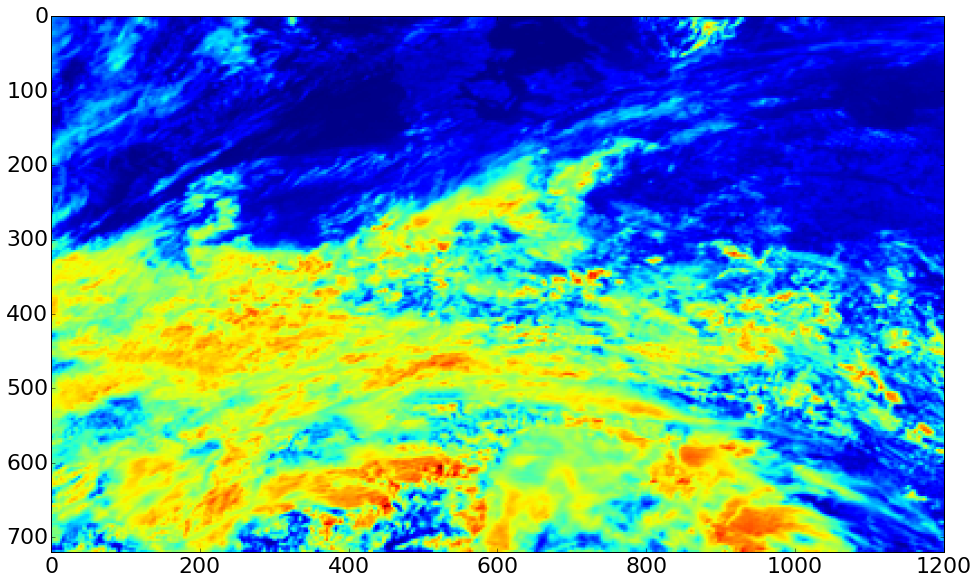

In [137]:
rad06, info = MSGtools.get_seviri_chan('VIS006', t, calibrate = True)
vis06 = MSGtools.rad2refl(rad06, info, t, 1.)

v = low2highres_decut(vis06)

pl.imshow(v)

hrv, info = MSGtools.get_seviri_chan('HRV', t, calibrate = True)
hrv = MSGtools.rad2refl(hrv, info, t, 1.)

hrvreg = deregion(res = 'high')
hrv = gi.cutout_fields(hrv, hrvreg)

In [127]:
hcoarse = scipy.ndimage.uniform_filter(h, 3)[1::3,1::3]

hcoarse = hcoarse.repeat(3, axis = 0).repeat(3, axis = 1)

1090
1117


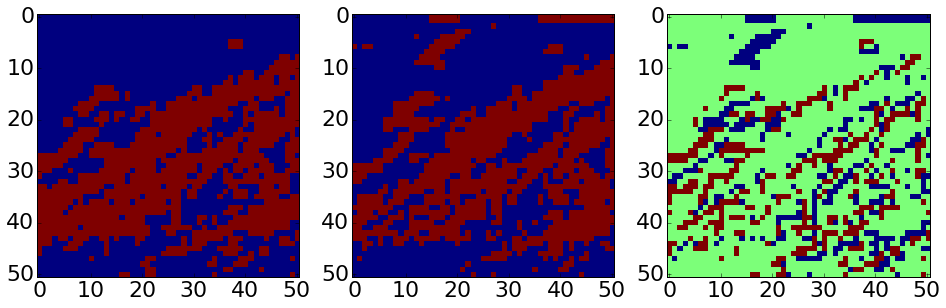

In [138]:
cmc = gi.cutout_field4box(hrvma, (200, 400), 50)
ccut = gi.cutout_field4box(cc, (200, 400), 50)
hc = gi.cutout_field4box(h, (200, 400), 50)
vc = gi.cutout_field4box(v, (200, 400), 50)
hcc = gi.cutout_field4box(hcoarse, (200, 400), 50)
hrvcut = gi.cutout_field4box(hrv, (200, 400), 50)

m = cmc & 0x1
mh = hc > 0.25

print m.sum()
print mh.sum()

pl.subplot(131)
pl.imshow(mh,interpolation = 'nearest')

pl.subplot(132)
pl.imshow(m, interpolation = 'nearest')

pl.subplot(133)
pl.imshow( mh - m, interpolation = 'nearest')




In [93]:
import skimage.feature
shift, error, diffphase = skimage.feature.register_translation(mh, m, 10)

print shift

[-1.  -0.9]


In [141]:
import skimage.feature
shift, error, diffphase = skimage.feature.register_translation(m, hrvcut, 10)

print shift

[ 0.  0.]


In [142]:
shift, error, diffphase = skimage.feature.register_translation(vc, hrvcut, 10)

print shift

[-0.3 -0.1]


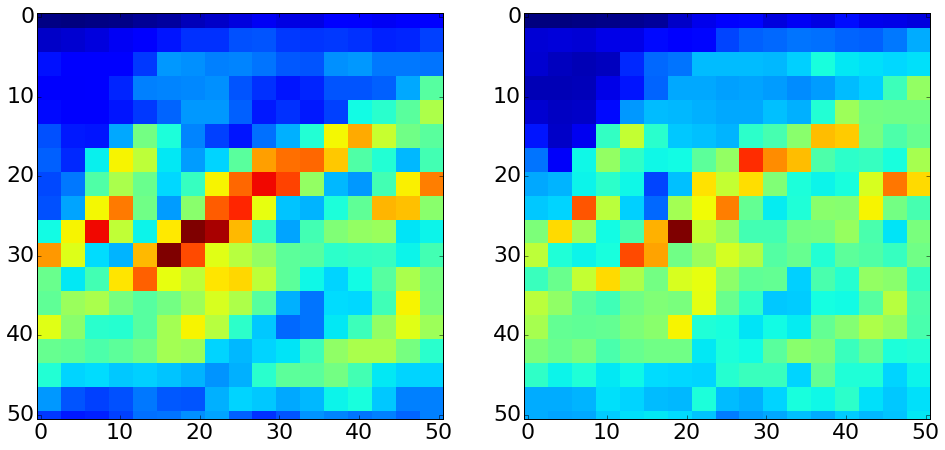

In [129]:
pl.subplot(121)
pl.imshow(vc, interpolation = 'nearest')

pl.subplot(122)
pl.imshow(hcc, interpolation = 'nearest')

0.190358904861
...take predefined marker field


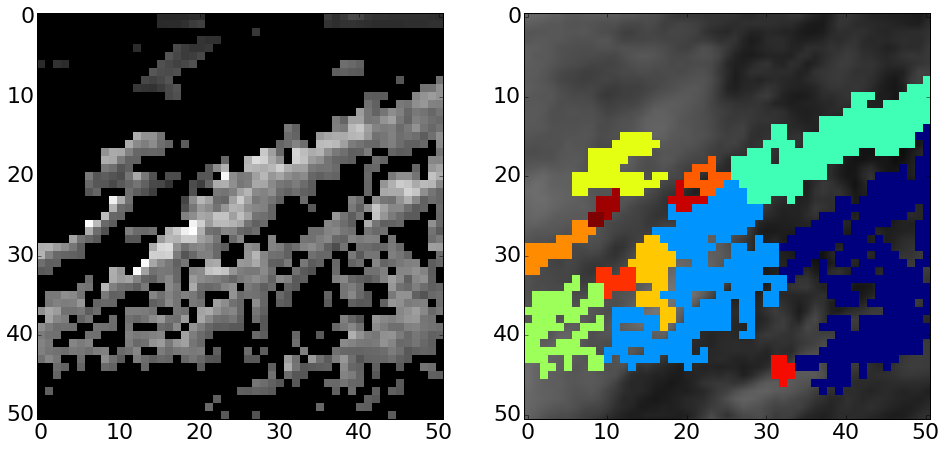

In [163]:
#hm = np.ma.masked_where((hrvma & 0x1) == 0, hrv)
hm = np.ma.masked_where(m==0, hc)
hm.data[hm.mask] = 0.

fthresh = 0.1
f = (hm - masked_gaussian_filter_nd(hm, 1))

print f.max()
f.data[f.mask] = 0.

s = seg.watershed_clustering(f, fthresh, marker_field = 'field', numberOfIterations=0)#marker_method='iterative_shrinking', marker_shrinkage_dmin = 0.1)
s = seg.watershed_clustering(hm, 0.1, marker_field = s, numberOfIterations=0)

s = seg.sort_clusters(s)
pl.subplot(121)
pl.imshow(hm.data, cmap = pl.cm.gray, interpolation = 'nearest')
#pl.imshow(f, interpolation = 'nearest')

pl.subplot(122)
pl.imshow(h, cmap = pl.cm.gray)
pl.imshow(np.log(s), interpolation = 'nearest')